### Processamento em Memória Cache, Frequência, Moda, Histograma e Análises Estatísticas

##### Carregamento e Pré-Processamento

In [1]:
import polars as pl
import matplotlib.pyplot as plt  
import seaborn as sns  

# Carrega o arquivo no modo lazy (não executa imediatamente)  
lazy_df = pl.scan_parquet("202501_NovoBolsaFamilia_polars.parquet")  

# Mostra o esquema (tipos de dados atuais)  
lazy_df.collect_schema()

Schema([('MÊS COMPETÊNCIA', Int64),
        ('MÊS REFERÊNCIA', Int64),
        ('UF', String),
        ('CÓDIGO MUNICÍPIO SIAFI', Int64),
        ('NOME MUNICÍPIO', String),
        ('CPF FAVORECIDO', String),
        ('NIS FAVORECIDO', Int64),
        ('NOME FAVORECIDO', String),
        ('VALOR PARCELA', String)])

In [2]:
# Converte VALOR PARCELA de str para float (substitui ',' por '.')  
# Converte MÊS REFERÊNCIA de int (ex: 202501) para datetime  
processed_df = (  
    lazy_df  
    .with_columns(  
        pl.col("VALOR PARCELA")  
          .str.replace(",", ".")  
          .cast(pl.Float64)  
          .alias("VALOR PARCELA"),  
        pl.col("MÊS REFERÊNCIA")  
          .cast(pl.String)  
          .str.strptime(pl.Date, "%Y%m")  
          .alias("DATA REFERÊNCIA")  
    )  
).collect()  # Executa as operações lazy  

# Verifica o resultado  
print(processed_df.head())  

shape: (5, 10)
┌────────────┬────────────┬─────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ MÊS COMPET ┆ MÊS        ┆ UF  ┆ CÓDIGO     ┆ … ┆ NIS        ┆ NOME       ┆ VALOR     ┆ DATA REFE │
│ ÊNCIA      ┆ REFERÊNCIA ┆ --- ┆ MUNICÍPIO  ┆   ┆ FAVORECIDO ┆ FAVORECIDO ┆ PARCELA   ┆ RÊNCIA    │
│ ---        ┆ ---        ┆ str ┆ SIAFI      ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│ i64        ┆ i64        ┆     ┆ ---        ┆   ┆ i64        ┆ str        ┆ f64       ┆ date      │
│            ┆            ┆     ┆ i64        ┆   ┆            ┆            ┆           ┆           │
╞════════════╪════════════╪═════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 202501     ┆ 202308     ┆ SP  ┆ 7071       ┆ … ┆ 2064389044 ┆ FERNANDA   ┆ 650.0     ┆ 2023-08-0 │
│            ┆            ┆     ┆            ┆   ┆ 5          ┆ RAMOS      ┆           ┆ 1         │
│            ┆            ┆     ┆            ┆   ┆            ┆ TEIXEIRA   ┆

##### Frequência e Moda


A frequência (ou distribuição de frequência) indica QUANTAS VEZES UM VALOR APARECE em um conjunto de dados. No contexto da nossa amostra, calcular a frequência por UF revela:

- Qual estado tem mais beneficiários (distribuição geográfica);
- Se há concentração de benefícios em determinadas regiões.

A moda é O VALOR QUE MAIS SE REPETE em uma variável. No caso da coluna VALOR PARCELA, ela mostra:

- O valor de benefício mais frequente pago aos beneficiários.

In [3]:
# Frequência de valores por UF  
freq_uf = processed_df["UF"].value_counts().sort("count", descending=True)  
print(freq_uf)  

# Moda do valor da parcela (valor mais comum)  
moda_valor = processed_df["VALOR PARCELA"].mode()  
print(f"Moda do valor da parcela: {moda_valor}")  

shape: (27, 2)
┌─────┬─────────┐
│ UF  ┆ count   │
│ --- ┆ ---     │
│ str ┆ u32     │
╞═════╪═════════╡
│ BA  ┆ 4919884 │
│ SP  ┆ 4892129 │
│ PE  ┆ 3157786 │
│ RJ  ┆ 3137344 │
│ MG  ┆ 3119226 │
│ …   ┆ …       │
│ TO  ┆ 309062  │
│ RO  ┆ 264180  │
│ AC  ┆ 261752  │
│ AP  ┆ 242729  │
│ RR  ┆ 158597  │
└─────┴─────────┘
Moda do valor da parcela: shape: (1,)
Series: 'VALOR PARCELA' [f64]
[
	600.0
]


##### Histograma

Um histograma é um gráfico de barras que representa A DISTRIBUIÇÃO DE FREQUÊNCIAS de uma variável contínua. Ele divide os dados em intervalos (chamados de "bins" ou "classes") e mostra quantas observações caem em cada intervalo.

Elementos-Chave:

- Eixo X: Valores da variável (no caso, VALOR PARCELA em R$);
- Eixo Y: Frequência (quantidade de beneficiários em cada faixa de valor);
- Barras: Altura proporcional à frequência de cada intervalo;

Além disso, esse gráfico mostra uma linha suave (o KDE - Kernel Density Estimation) que estima a densidade de probabilidade dos dados (opcional, mas útil para visualizar a forma da distribuição).

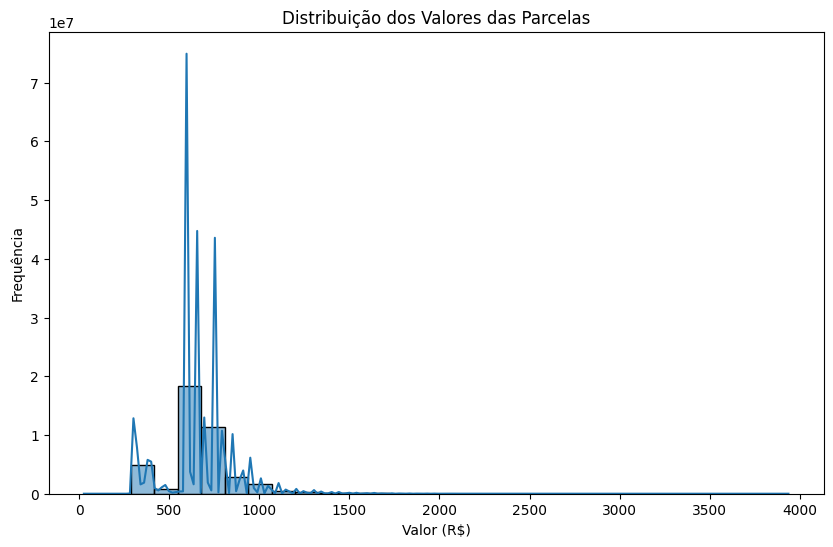

In [4]:
# Configuração do gráfico  
plt.figure(figsize=(10, 6))  
sns.histplot(processed_df["VALOR PARCELA"].to_numpy(), bins=30, kde=True) # BINS: divide os dados em 30 intervalos (ajustável para mais ou menos detalhes) 
plt.title("Distribuição dos Valores das Parcelas")  
plt.xlabel("Valor (R$)")  
plt.ylabel("Frequência")  
plt.show()  

No dataset do Bolsa-Família, o histograma de VALOR PARCELA nos permite responder perguntas críticas:

1. Forma da Distribuição:

- Assimetria: A distribuição é simétrica, inclinada à direita (valores altos são raros) ou à esquerda (valores baixos são raros)?

Exemplo: Se o histograma tem uma cauda longa à direita, poucos beneficiários recebem valores muito altos.

- Modalidade: Tem um pico (unimodal) ou vários picos (multimodal)?

Unimodal sugere um valor "típico" predominante (ex.: R$ 600).

2. Centralidade e Dispersão:

- Onde os valores se concentram? (Ex.: Pico em R$ 500–700).

- Qual a variação? (Intervalo entre o menor e maior valor).

3. Identificação de Outliers:

- Barras isoladas à direita indicam valores anormalmente altos (possíveis erros ou casos excepcionais).

4. Comparação com Políticas Públicas:

- Se o governo define faixas de benefício (ex.: R$ 300–R$ 600), o histograma mostra se a maioria está dentro desses limites.

>>> Outras abordagens utilizando histograma: verifique a frequência dos benefícios de acordo com intervalos de tempo ou regiões específicas

C:\Users\klemd\AppData\Local\Temp\ipykernel_14448\2383134124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


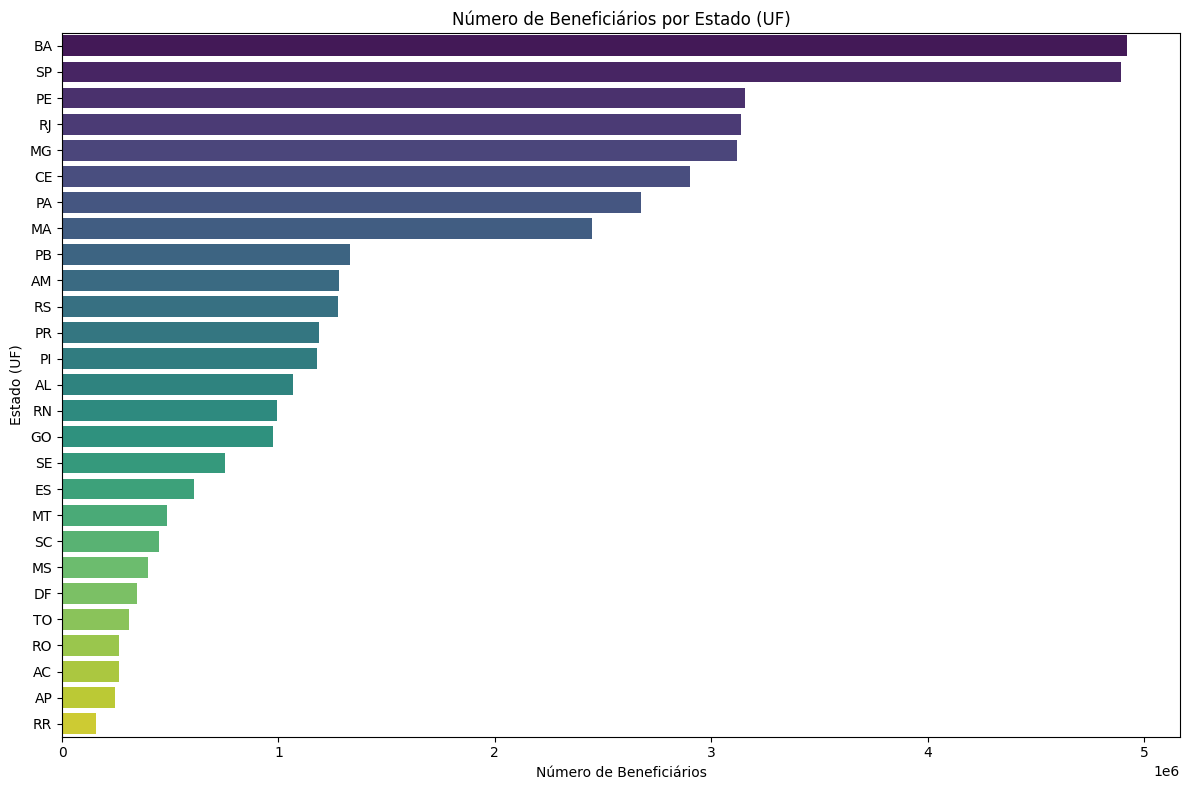

In [5]:
plt.figure(figsize=(12, 8))
sns.countplot(
    data=processed_df,
    y="UF",
    order=freq_uf["UF"],  # Usando a ordem correta das UFs
    palette="viridis"
)
plt.title("Número de Beneficiários por Estado (UF)")
plt.xlabel("Número de Beneficiários")
plt.ylabel("Estado (UF)")
plt.tight_layout()
plt.show()